In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import os
import ray
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import ASHAScheduler
import tempfile

import sys
sys.path.append('../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Train_Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


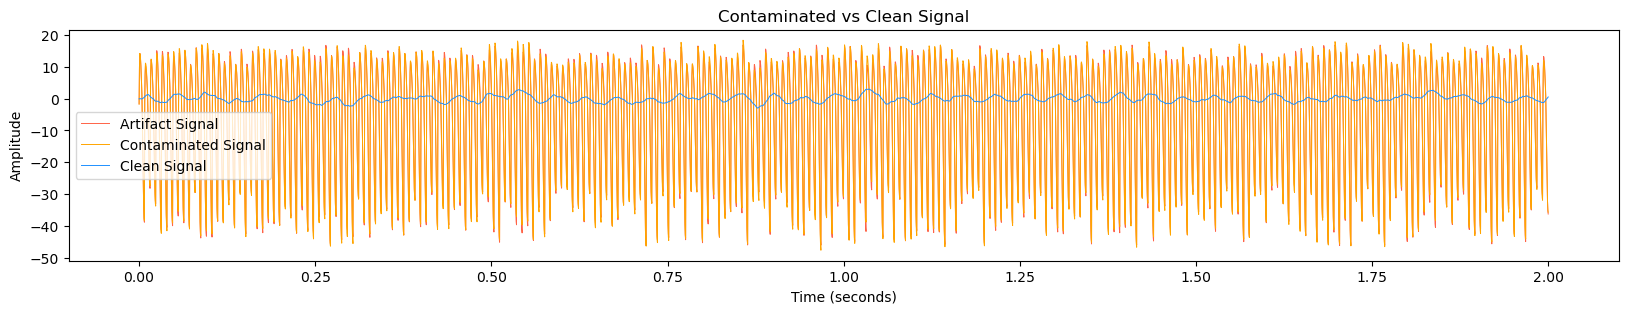

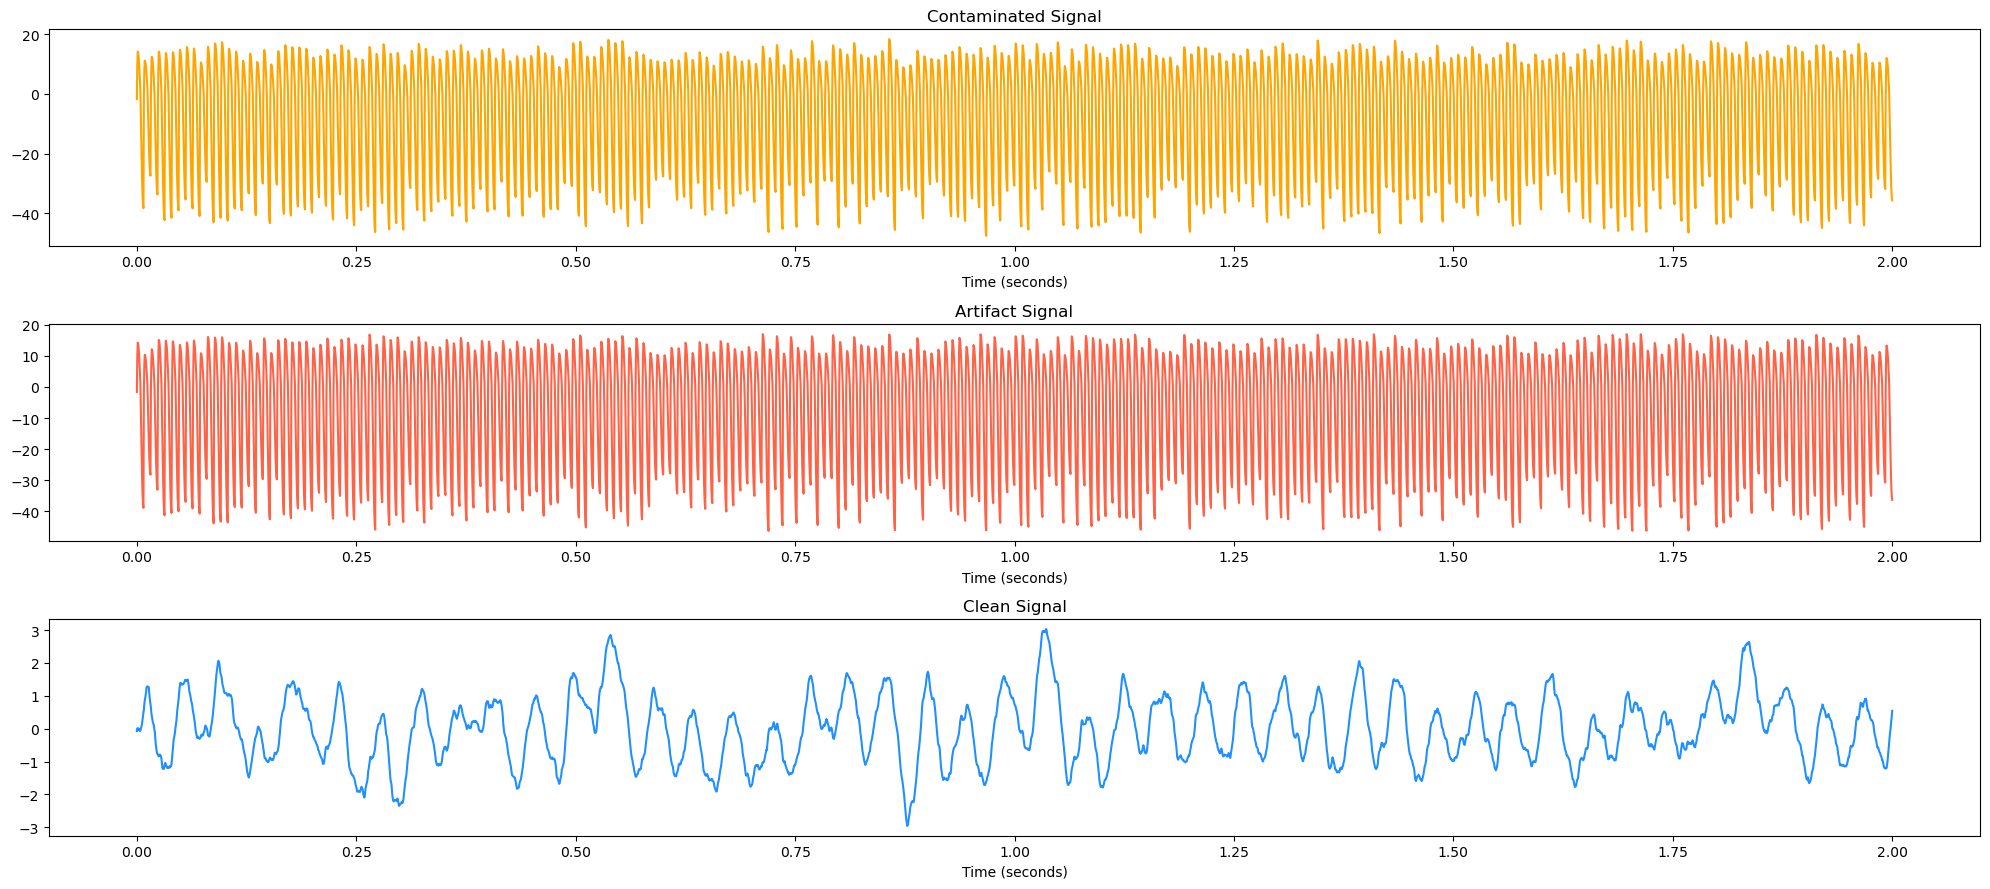

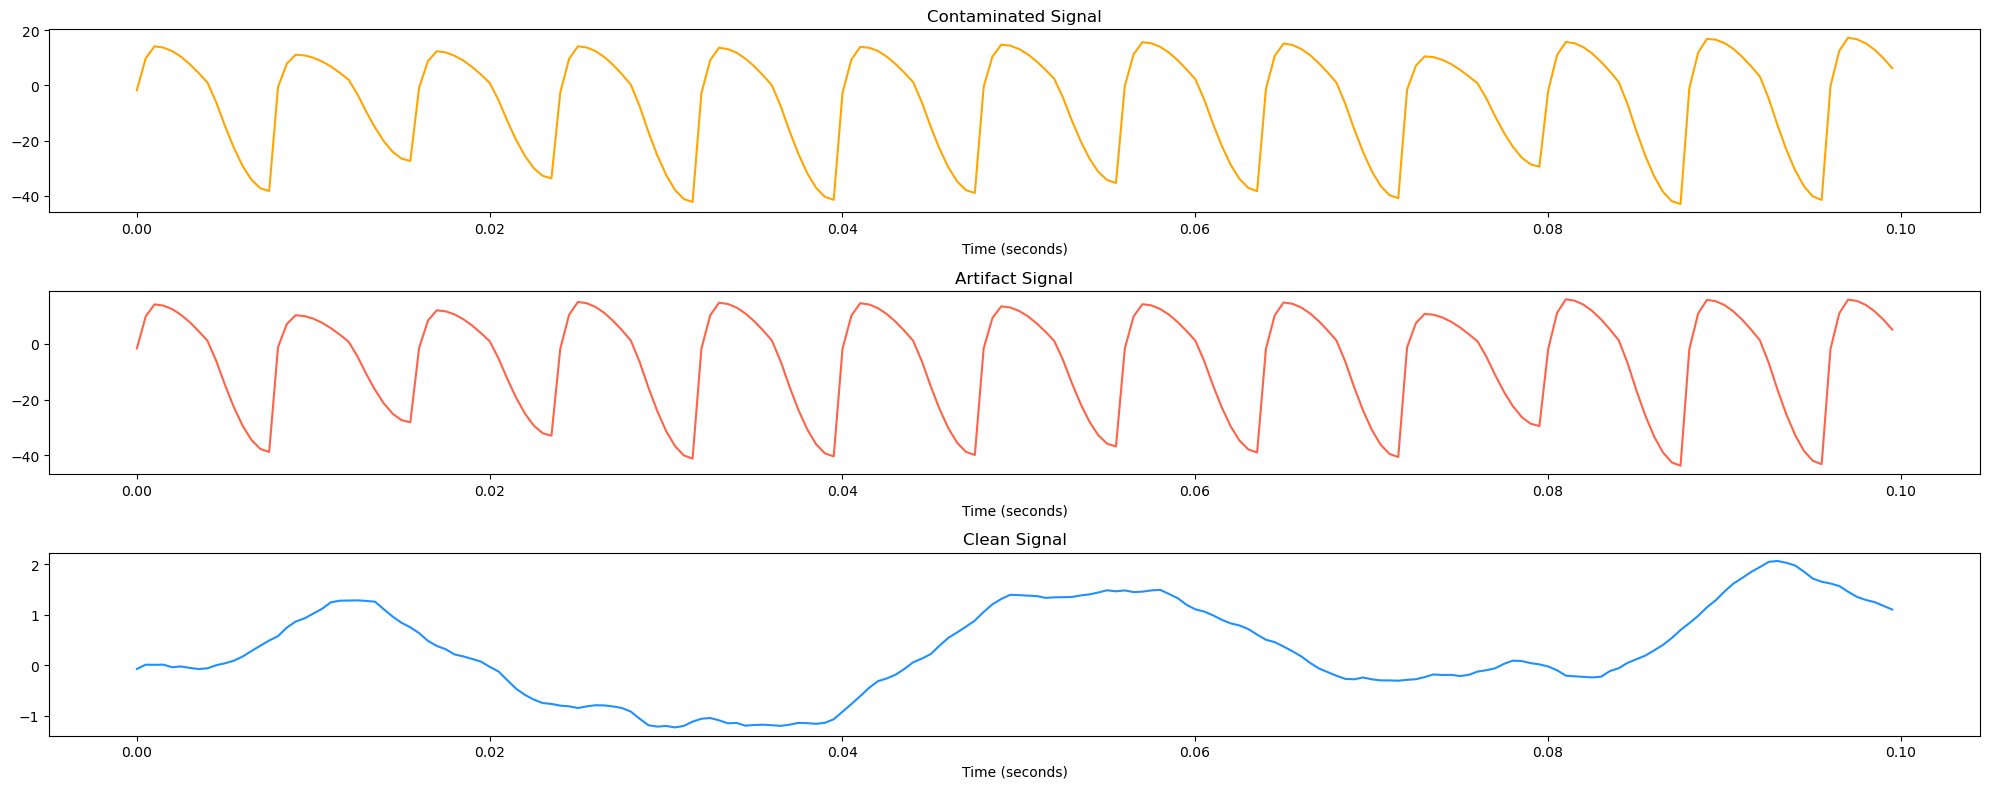

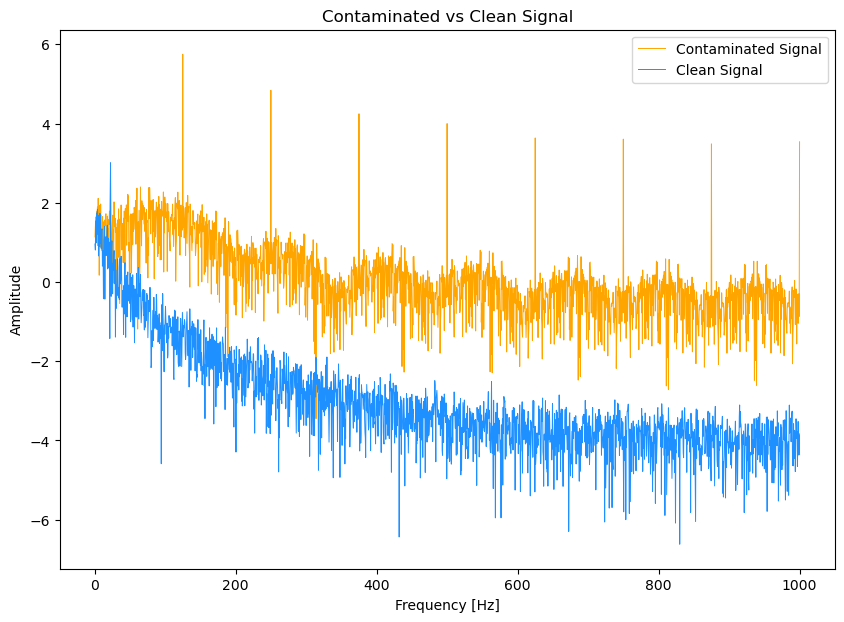

In [2]:
# 데이터 load & plot
datapath='../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

<Time Domain Error>
Mean Absolute Error: 15.513215774726993
Mean Squared Error: 383.8545551798977


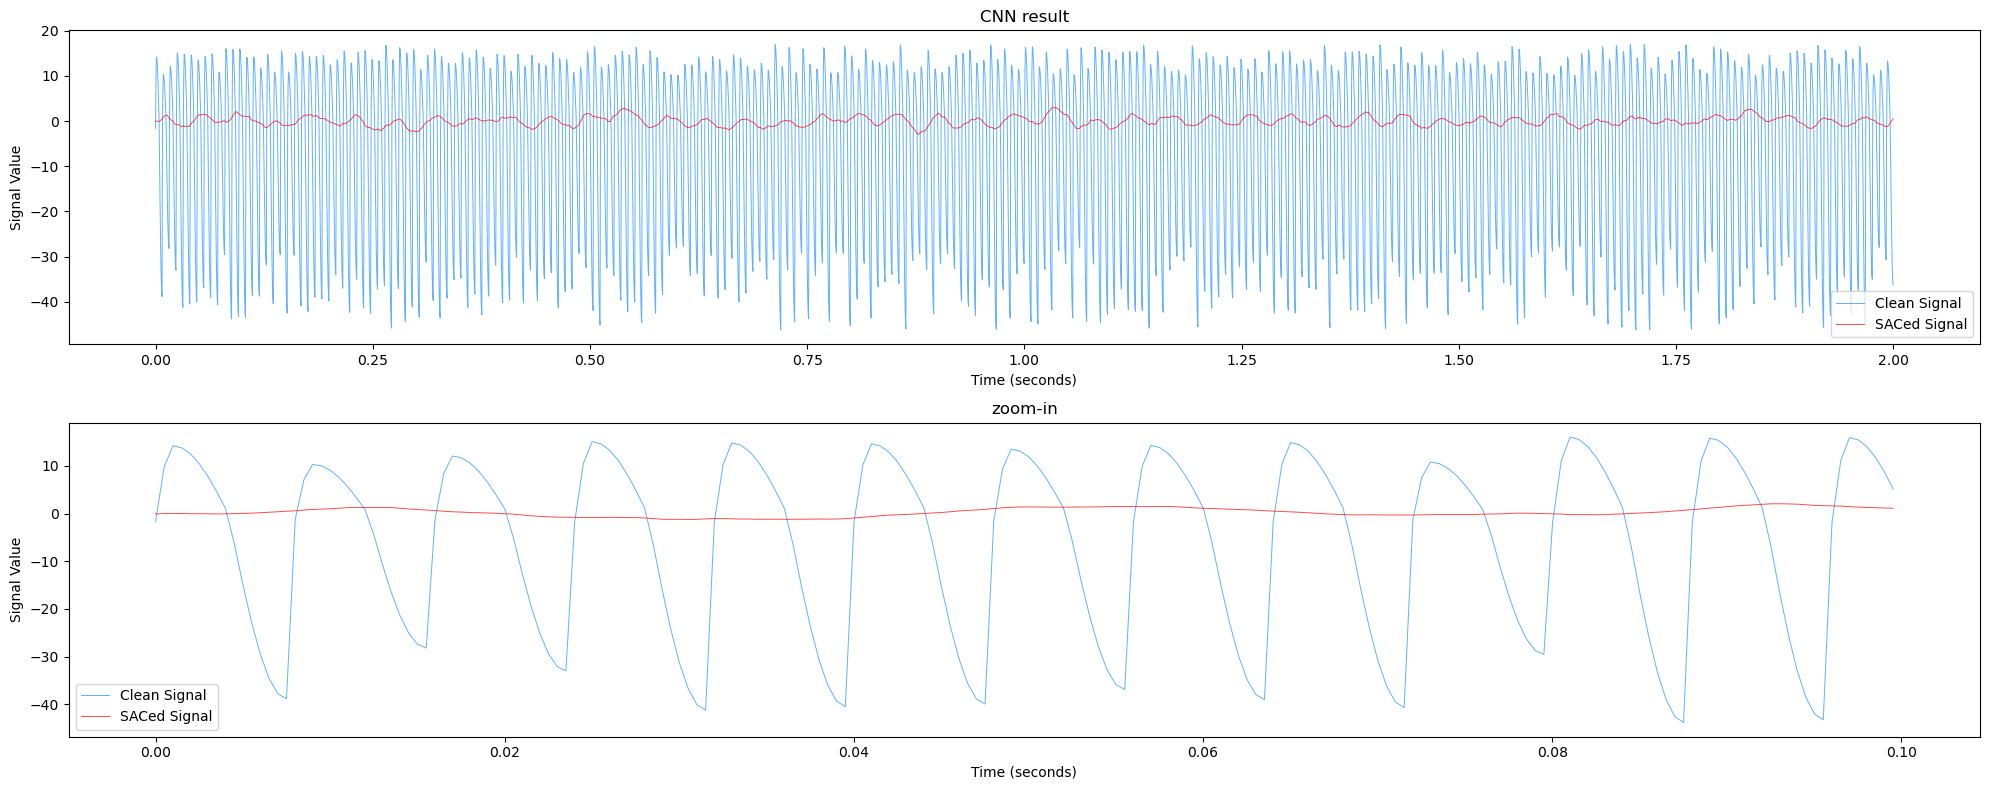

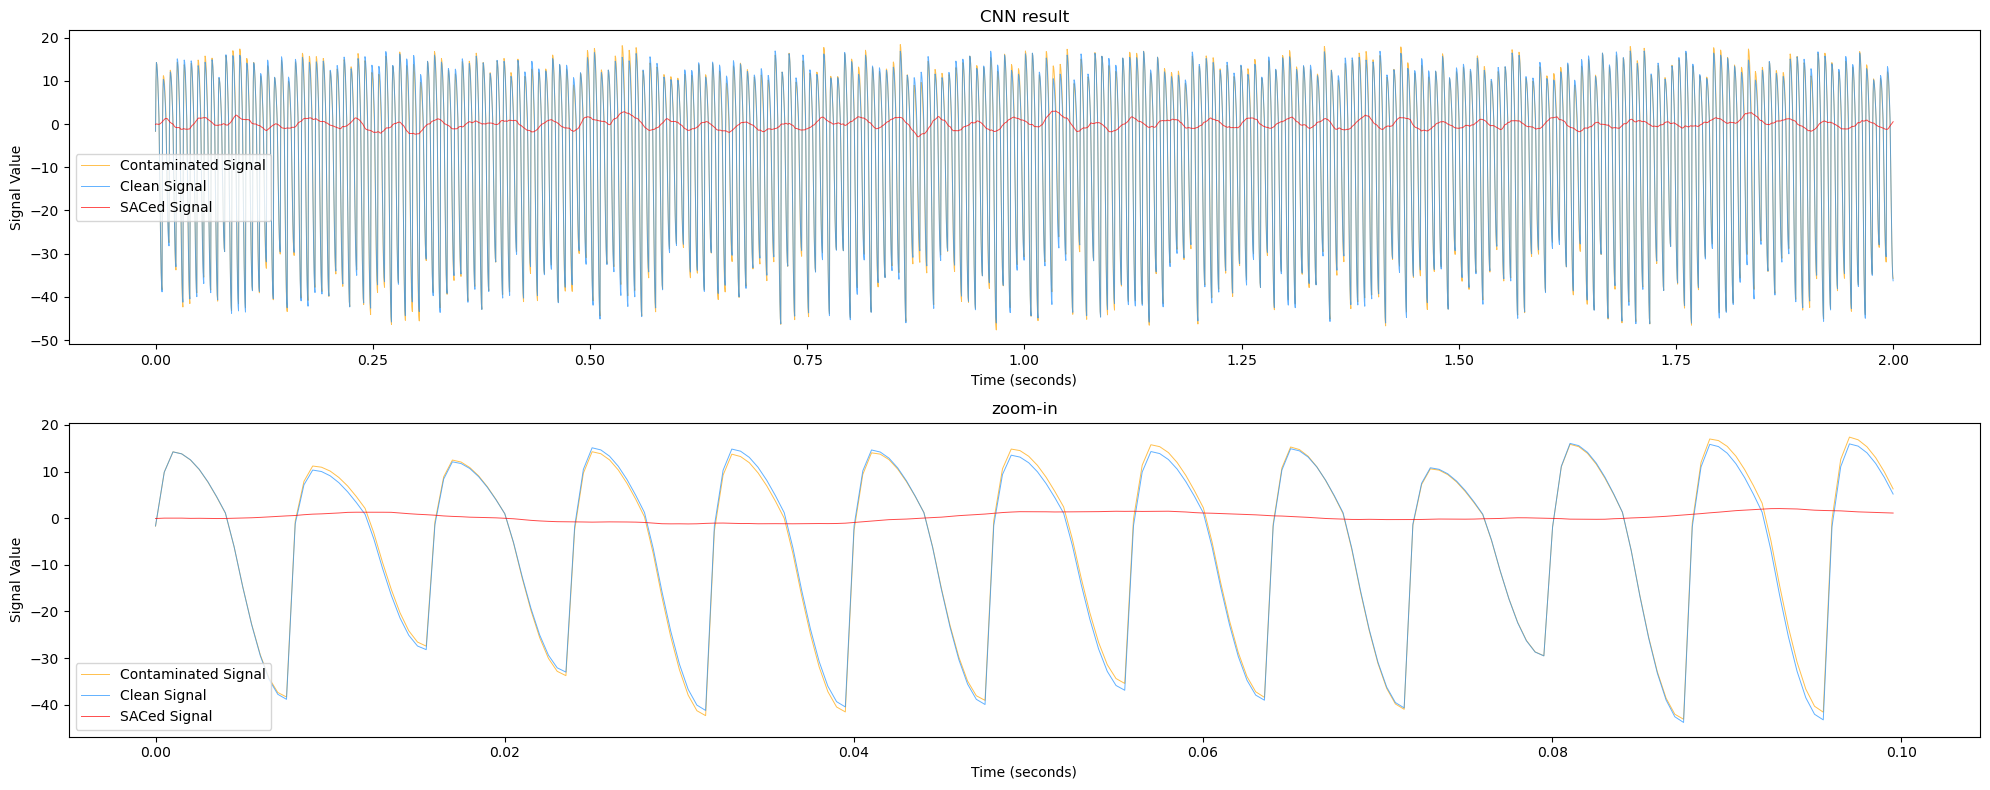

<Frequency Domain Error>
Mean Absolute Error: 855.3256080918252
Mean Squared Error: 684395411.5450001


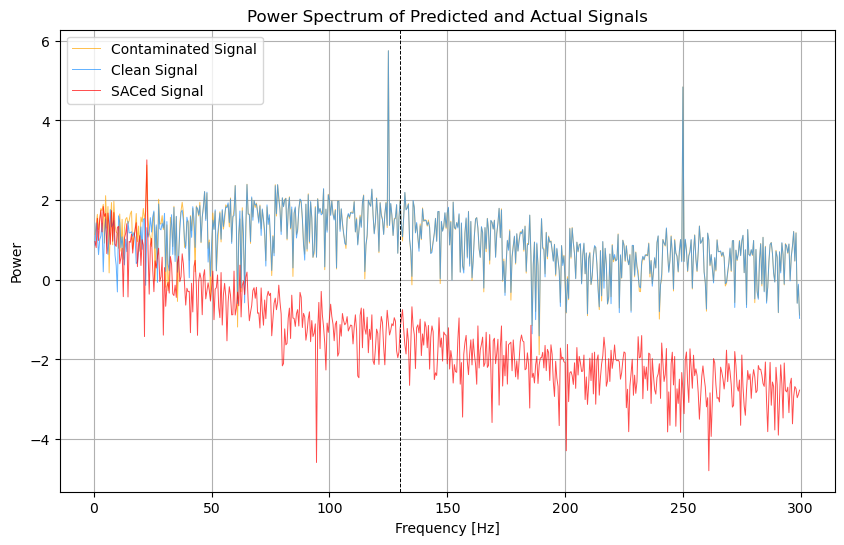

In [3]:
Result_Plot(Contaminated_data, Clean_data, Artifact_data)

In [ ]:
# 데이터 load & plot
fpath = "../../data/synthetic_data/"

Contaminated_data = np.load(fpath + "contaminated_by_realistic" + ".npy")
Clean_data = np.load(fpath + "clean_data" + ".npy")
Artifact_daata = Contaminated_data - Clean_data

# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

print(Contaminated_data.shape)
print(Clean_data.shape)

In [ ]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1]) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

#train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
#test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

#train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dim=16, kernel_size=3, dropout_rate=0.25):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_dim, kernel_size, padding=1),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size, padding=1),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.GELU(),
            nn.Conv1d(hidden_dim * 2, hidden_dim, kernel_size, padding=1),
            nn.GELU(),
            nn.Conv1d(hidden_dim, out_channels, kernel_size, padding=1)
        )
        
        self.drop = nn.Dropout1d(dropout_rate)

    def forward(self, x):  # x: B x 1 x T
        x = self.layer1(x)
        return x

model = CNN().to(device)
print(model)

In [ ]:
import os
import ray
from ray import tune

os.environ["RAY_TMPDIR"] = "C:/ray_tmp"

ray.shutdown()
ray.init()

def train_cnn(config):

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config["batch_size"], shuffle=False)

    model = CNN(config["hidden_dim"], config["kernel_size"], config["dropout_rate"]).to(config["device"])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # 평균 손실값을 기록
        tune.report(loss=running_loss / len(train_loader))

In [ ]:
# 임시 디렉토리 경로 변경

def main(num_samples=1000, max_num_epochs=10, gpus_per_trial=0):
    config = {
        "hidden_dim": tune.choice([16, 32, 64]),
        "kernel_size": tune.choice([3, 5, 7]),
        "dropout_rate": tune.uniform(0.1, 0.5),
        "lr": tune.loguniform(1e-4, 1e-2),
        "batch_size": tune.choice([16, 32, 64]),
        "epochs": max_num_epochs,
        "device": "cuda" if torch.cuda.is_available() else "cpu"
    }

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )
    
    tuner = Tuner(
        tune.with_resources(
            tune.with_parameters(train_cnn),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min", "last")

    print(f"Best trial config: {best_result.config}")
    print(f"Best trial final validation loss: {best_result.metrics['loss']}")

# 실행
if __name__ == "__main__":
    main(num_samples=1000, max_num_epochs=10, gpus_per_trial=0)